# Homework 2
#### Yufeng Yuan
#### yy208@duke.edu

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
from skimage.viewer import ImageViewer
import skimage.filters as filters
import glob
import re
import os
from time import gmtime, strftime, sleep
from copy import deepcopy
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0) 

In [16]:
def move_focus(sid=1, step=0):
    cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(step)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    #return pop.stdout


def take_photos(sid=1, step=100, iters=1, start=-1500):
    subprocess.run('rm dbGrab*', \
               stdout=subprocess.PIPE, shell=True)
    subprocess.run('rsh ubuntu@10.0.1.4 "rm dbGrab*"', \
               stdout=subprocess.PIPE, shell=True)
    cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(start)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    for i in range(iters):
        subprocess.run('rsh ubuntu@10.0.1.4 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                --file-name dbGrab_'+str(i*step)+' --image-res 8"', stdout=subprocess.PIPE, shell=True)
        cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(step)+'"'
        subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    subprocess.run('rcp ubuntu@10.0.1.4:dbGrab* .', \
                stdout=subprocess.PIPE, shell=True)
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    return pop

def read_eval(x=0, y=0, h=2160, w=3840):
    names = os.listdir()
    pics = []
    scores = []
    for name in sorted(names):
        if name[:6] == 'dbGrab':
            pic = imio.imread(name)
            pics.append(pic)
            scores.append(np.sum(filters.sobel(pic[x:x+w, y:y+h,0])))
    ind = scores.index(max(scores))
    #imio.imshow(pics[ind])
    focus = 100 * ind
    return focus, pics[ind], scores

def auto_focus(sid=1, region=[0,0,2160,3840]):
    take_photos(sid, 100, 10)
    x, y, h, w = region
    focus, pics, scores = read_eval(x, y, h, w)
    start = -1500
    cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(start)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    cmD='rsh ubuntu@10.0.1.4 "python2 ~/bin/moveFocusMotor.py '+str(sid+1)+' '+str(focus+100)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    pop = take_photos(sid, 0, 1, 0)
    imio.imshow(pop)
    return focus, pop, scores

def focus_stacking():
    names = os.listdir()
    pics = np.zeros([2160, 3840, 3, 2], dtype='int8')
    scores = np.zeros([2160, 3840, 2])
    index = 0  
    for name in names:
        if name[:8] == 'original':
            pic = imio.imread(name)
            pics[:, :, :, index] = pic
            scores[:, :, index] = filters.laplace(pic[:, :, 0])
            index += 1
    score = np.argmax(scores, axis=2)
    # unable to use matrix operation due to memory error
    # instead naive implementation with loops
    pic_new = deepcopy(pic)
    for i in range(2160):
        for j in range(3840):
            pic_new[i, j, :] = pics[i, j, :, score[i, j]]
    imio.imsave('naive_focus_stack.jpg', pic_new)

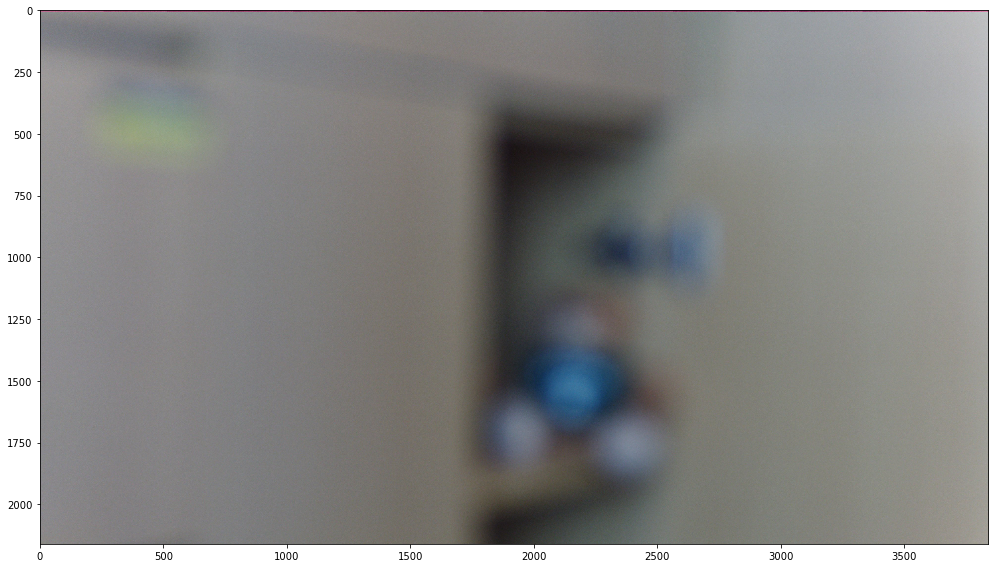

In [158]:
# Task 1
move_focus(1, -1000)
pop = take_photos(1, 0, 1, 0)
imio.imshow(pop)

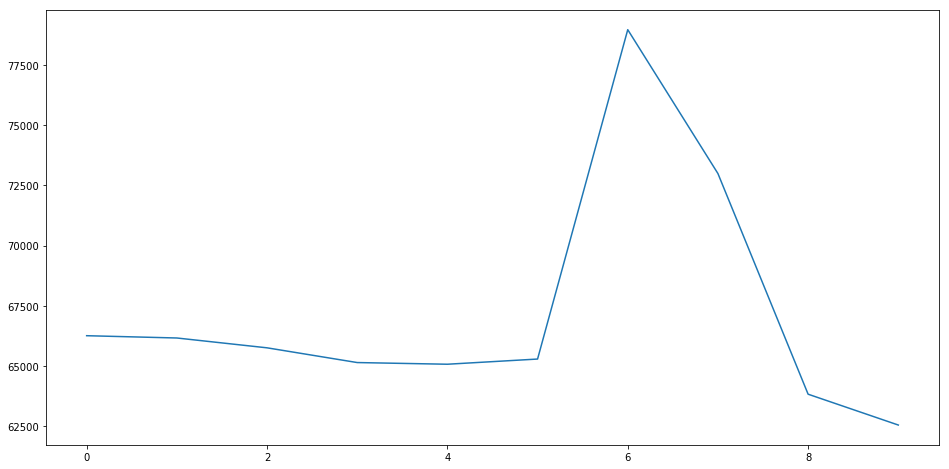

In [146]:
# Task 2
take_photos(1, 100, 10)
focus, pic, scores = read_eval()
plt.plot(scores)

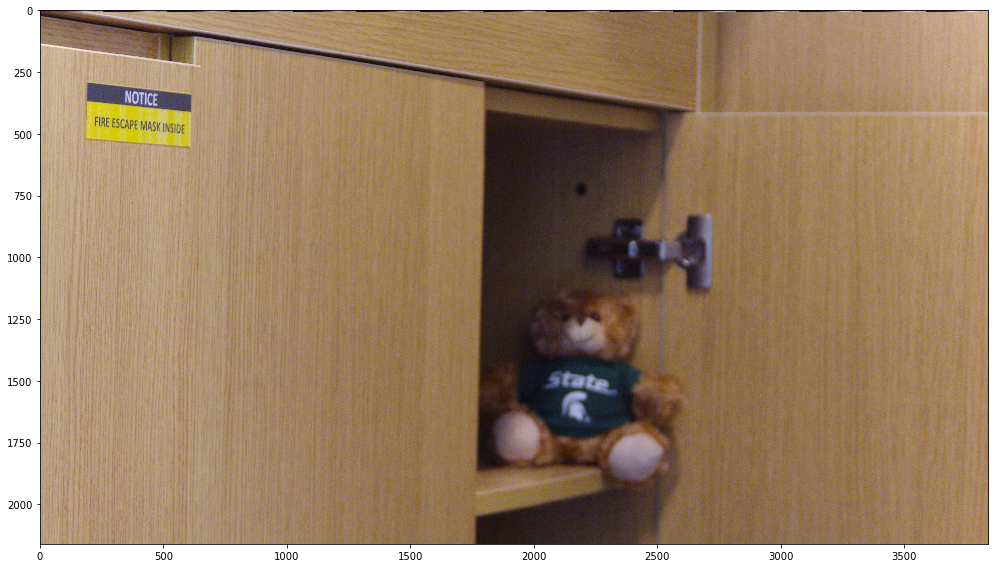

In [148]:
imio.imshow(pic)

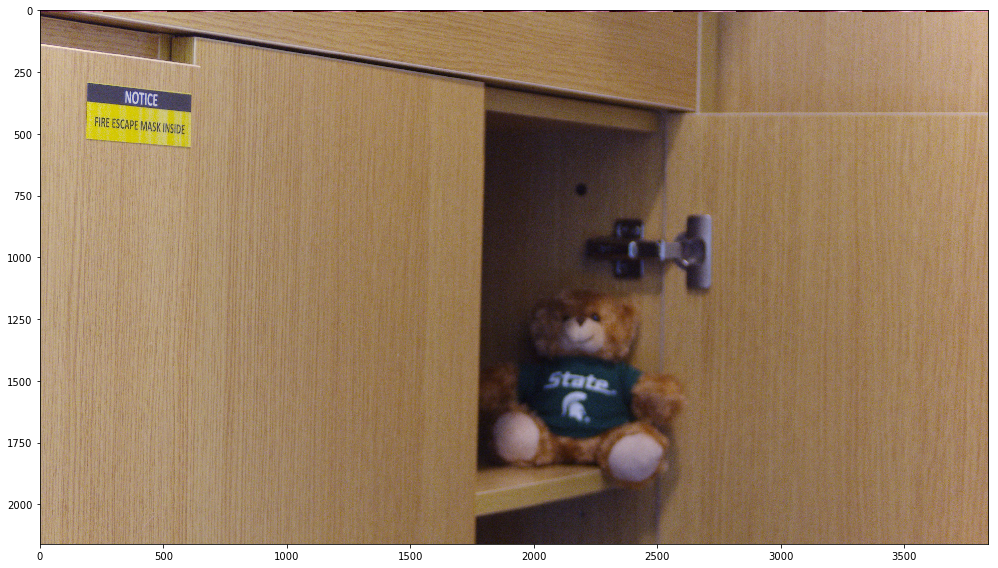

In [151]:
# Task 3
focus, pic, scores = auto_focus()

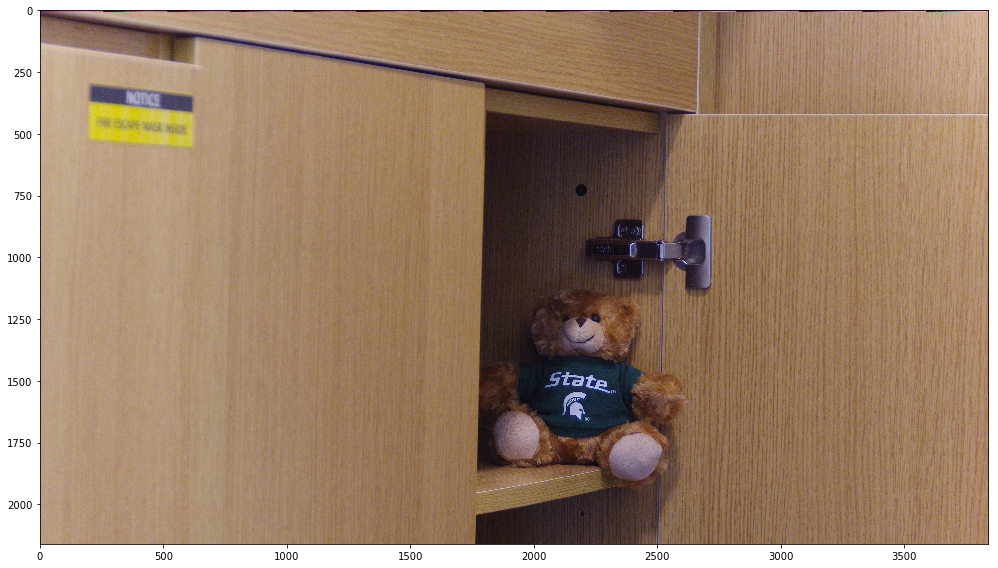

In [152]:
# Task 4
focus, pic, scores = auto_focus(1, [1000, 2000, 1000, 1000])

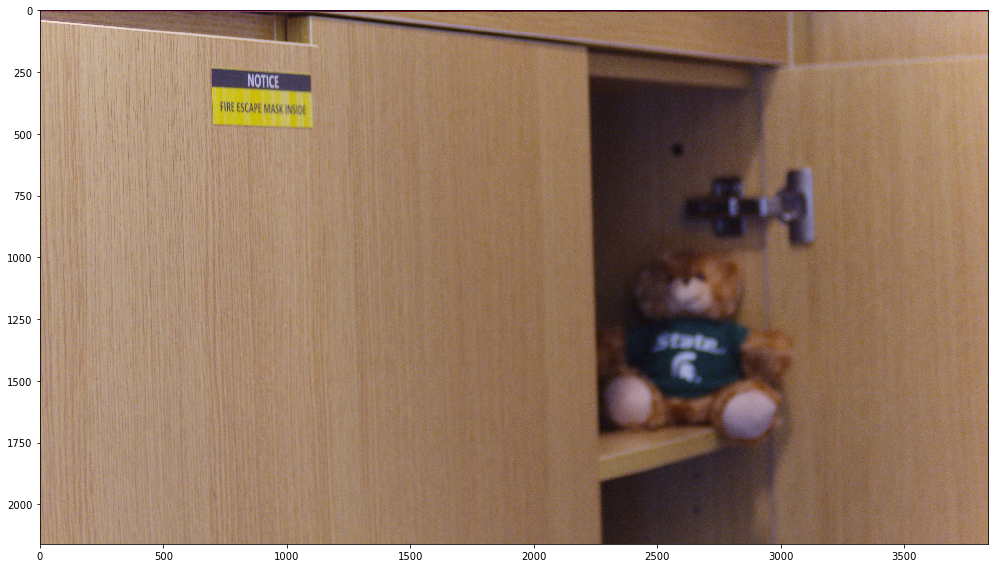

In [155]:
# Task 5
focus_0, pic_0, scores_0 = auto_focus(0, [0, 500, 500, 500])

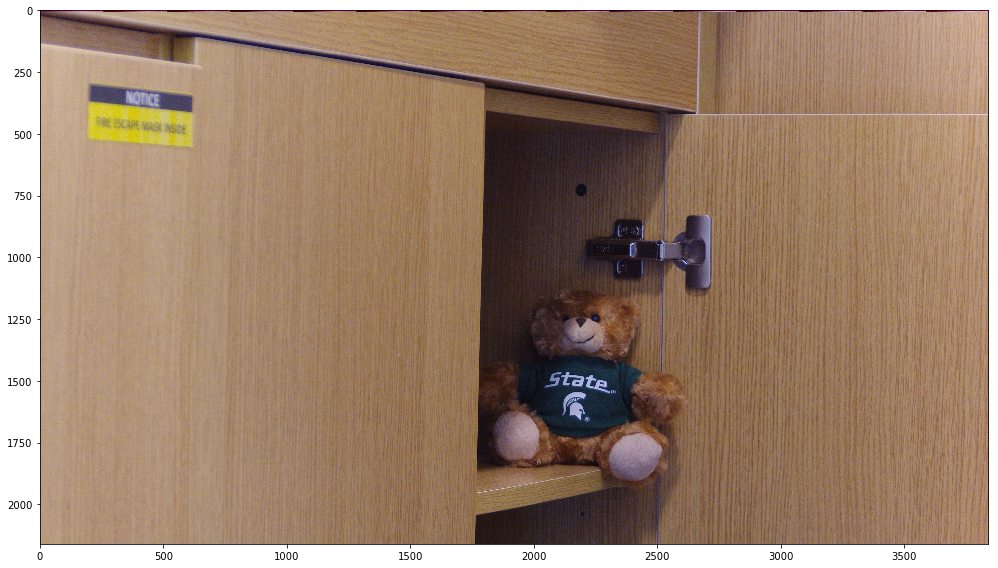

In [154]:
focus_1, pic_1, scores_1 = auto_focus(1, [500, 2000, 500, 500])

In [17]:
# Extra Credit:
# Due to the limited amount of time, I did this without images alignment, so the output image might not look so good
focus_stacking()

#### Original Image 1
<img src="original_1.jpg">

#### Original Image 2
<img src="original_2.jpg">

#### Image after Simple Focus Stacking
<img src="naive_focus_stack.jpg">